## 0. Getting started <a id="importing"></a>

This notebook is based in part of IBM's tutorial "Calibrating Qubits with Qiskit Pulse": https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-openpulse.html

We'll first get our basic dependencies set up and ready to go. Since we want to use real, noisy devices for our calibration experiments in this notebook, we need to load our IBMQ account and set the appropriate backend.

In [3]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit.providers.aer.pulse import *
from qiskit import Aer

In [6]:
provider = IBMQ.load_account()

IBMQAccountCredentialsNotFound: 'No IBM Quantum Experience credentials found.'

In [7]:


provider = IBMQ.load_account()
armonk_backend = provider.get_backend('ibmq_armonk')

armonk_system_model = PulseSystemModel.from_backend(armonk_backend)

armonk_backend = provider.get_backend('ibmq_armonk')

simulator_backend = Aer.get_backend('pulse_simulator')


IBMQAccountCredentialsNotFound: 'No IBM Quantum Experience credentials found.'

We verify that the backend supports Pulse features by checking the backend configuration. The config provides us with general information about the structure of the backend setup.

In [20]:
armonk_backend_config = armonk_backend.configuration()
assert armonk_backend_config.open_pulse, "Backend doesn't support Pulse"

armonk_backend_config = armonk_backend.configuration()
armonk_backend_defaults = armonk_backend.defaults()We verify that the backend supports Pulse features by checking the backend configuration. The config provides us with general information about the structure of the backend setup.

We prepare now a few things about the hardware configuration including the timing. 

In [3]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes

from qiskit import assemble

import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds


dt = armonk_backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

# We will work with qubit 0
qubit = 0

# Find out which group of qubits need to be acquired with this qubit
#meas_map_idx = None
#for i, measure_group in enumerate(armonk_backend_config.meas_map):
#    if qubit in measure_group:
#        meas_map_idx = i
#        break
#assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

### Collect the necessary channels
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

qubit_frequency = armonk_backend_defaults.qubit_freq_est[qubit]

# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(armonk_backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)


Sampling time: 0.2222222222222222 ns


Excecute either this cell, or the one below to switch between experimenting on the real device at IBM or the simulator. 

We suggest to use the simulator to debug the pulse sequences and the basic physics. Once you are familiar with it you should use the real device as this is how you learn about the actual system including its imperfections. 

In [46]:

simulator = True
#simulator = False            # toogle this line off to switch to the simulator or keep it in to 

if simulator:

    actual_backend = simulator_backend

    measure = pulse.Schedule((0, pulse.Acquire(160, pulse.AcquireChannel(0), pulse.MemorySlot(0))), name='acquire')

    # cutoff dimensions
    dim_oscillators = 3

    # single oscillator drift parameters
    oscillator_freqs = [qubit_frequency]
    anharm_freqs = [-0.33e9]

    # drive strengths
    drive_strengths = [0.005e9]

    # specify coupling as a dictionary; here the qubit pair (0,1) is coupled with
    # strength 0.002e9, and the qubit pair (1,2) is coupled with strength 0.001e9
    coupling_dict = {}

    # time leave as found from armonk
    #dt = 0.2e-8 


    # create the model
    system_model = duffing_system_model(dim_oscillators=dim_oscillators,
                                         oscillator_freqs=oscillator_freqs,
                                         anharm_freqs=anharm_freqs,
                                         drive_strengths=drive_strengths,
                                         coupling_dict=coupling_dict,
                                         dt=dt)

    #system_model._qubit_freq_est = [armonk_backend_defaults.qubit_freq_est[qubit]]
    #system_model._meas_freq_est = [armonk_backend_defaults.qubit_freq_est[qubit]]
    #system_model._qubit_lo_freq = 5e9

    print(system_model._meas_freq_est)
    print(system_model._qubit_freq_est)
    #print(system_model.qubit_lo_freq)
    #print(system_model.calculate_channel_frequencies())
else: 
    #use the real device!!!
    actual_backend = armonk_backend

    inst_sched_map = armonk_backend_defaults.instruction_schedule_map
    measure = inst_sched_map.get('measure', qubits=armonk_backend_config.meas_map[meas_map_idx])


In [39]:
print(armonk_backend_defaults.meas_freq_est[qubit])

6993427855.0


## 1. Rabi flops <a id="Rabi flops"></a>



In [47]:


# Construct the pulse lengths
time_min_ns = 4*16* dt / ns    # minimual allowable time
time_max_ns = 500
time_step_ns = time_max_ns/50
times_ns = np.arange(time_min_ns, time_max_ns, time_step_ns)
# Convert to units of dt
#sigma_times_dt = sigmas_ns * ns / dt
# We will use the same `pi_pulse` and qubit frequency that we calibrated and used before


drive_amp = 0.9

# Create schedules for the experiment 


rabi_schedules = []

    
for ti in times_ns:
    drive_samples = get_closest_multiple_of_16(ti * ns/dt)       # The width of the pulse in units of dt

    drive_pulse = pulse_lib.constant(duration=get_closest_multiple_of_16(ti * ns/dt)   ,
                                 amp=drive_amp,
                                 name='Rabi_sweep_excitation_pulse')

    
    this_schedule = pulse.Schedule(name=f"Rabi = {ti} ns")
    this_schedule += Play(drive_pulse, drive_chan)
        # The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)


num_shots_per_point = 1024
rabi_scan_program = assemble(rabi_schedules,
                                   backend=actual_backend, 
                                   meas_level=2,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   qubit_lo_freq = [qubit_frequency],
                                #  schedule_los=[{drive_chan: qubit_frequency}] * len(times_ns)
                                #  meas_lo_freq = actual_backend_defaults.meas_freq_est
                                )


#print("\n",frequency_sweep_program)


    
    

In [ ]:
#run the job

import matplotlib.pyplot as plt

if simulator: 
    print("Simulating")
    job = simulator_backend.run(rabi_scan_program,system_model)
else:
    print("Using armonk backend")
    job = armonk_backend.run(rabi_scan_program)

print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)
rabi_scan_results = job.result(timeout=120) # timeout parameter set to 120 seconds


Using armonk backend
5fa4867288b1a50013c7f025
Job Status: job is queued (5)     

In [ ]:
if(not simulator):
    job.error_message()

In [ ]:
rabi_values = []
for i in range(len(rabi_scan_results.results)):
    # Get the results from the ith experiment
    res = rabi_scan_results.get_counts(i).get('1') if rabi_scan_results.get_counts(i).get('1') else 0   # it can happen that no excitation is recorded in which case the counts will be "none"

    rabi_values.append(res/num_shots_per_point)

#print(np.real(sweep_values))
plt.scatter(times_ns, rabi_values, color='black') # plot real part of sweep values
plt.xlim([0, max(times_ns)])
plt.ylim([0, 1])
plt.xlabel("Time (ns)")
plt.ylabel("Probability")
plt.show()

In [37]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

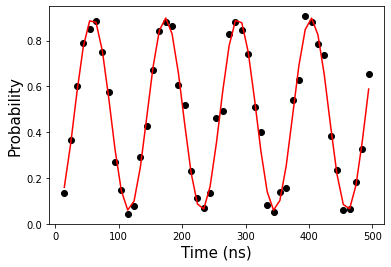

In [19]:
fit_params, y_fit = fit_function(times_ns,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [1, 0.1, 100, 0])

plt.scatter(times_ns, rabi_values, color='black')
plt.plot(times_ns, y_fit, color='red')

plt.xlabel("Time (ns)", fontsize=15)
plt.ylabel("Probability", fontsize=15)
plt.show()

